(260, 400, 4)


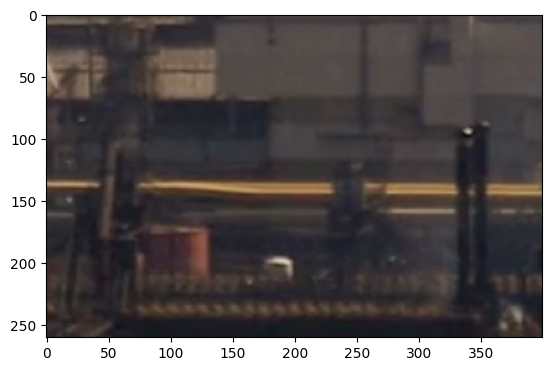

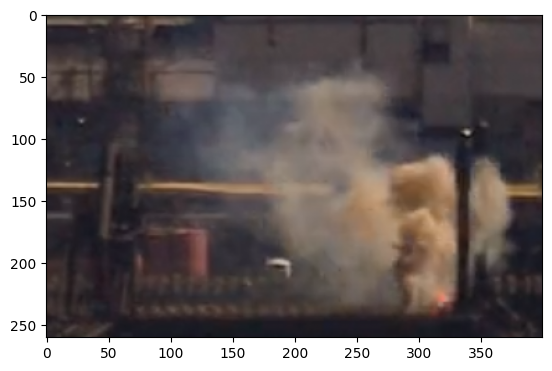

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11016663187968993..125.48053200605274].


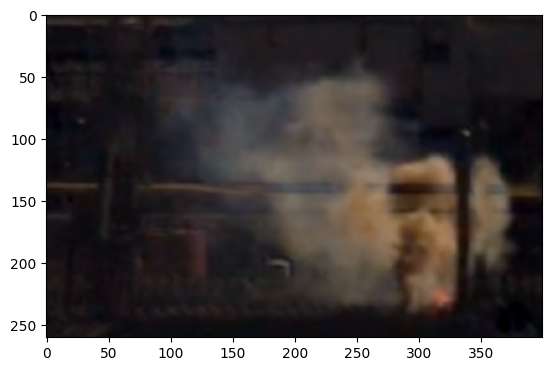

In [34]:
import io
from matplotlib import pyplot as plt
from scipy.optimize import lsq_linear
from scipy.sparse import csr_matrix
import numpy as np
import requests
from PIL import Image

xvar = 0
yvar = 1

# def solve(equations):
#     # Solve using lsq_linear
#     A = []
#     b = []
#     for eq in equations:
#         row = [0] * 2
#         for coef, var in eq[:-1]:
#             row[var] = coef
#         A.append(row)
#         b.append(eq[-1])
#     A = np.array(A)
#     b = np.array(b)
#     res = lsq_linear(A, b)
#     return res.x

def solve_sparse(equations):
    rowidx = []
    colidx = []
    data = []
    b = []
    for i, eq in enumerate(equations):
        for coef, var in eq[:-1]:
            rowidx.append(i)
            colidx.append(var)
            data.append(coef)
        b.append(eq[-1])
    nvars = max(colidx) + 1
    A = csr_matrix((data, (rowidx, colidx)), shape=(len(equations), nvars))
    b = np.array(b)
    res = lsq_linear(A, b)
    return res.x

def solve_haze_removal(i0, i1):
    height, width = i0.shape[:2]

    # Number of variables: each pixel has 4 variables (o, r, g, b)
    num_vars = height * width * 4

    # Helper functions to get variable indices
    def h(i, j, k):
        return (i * width + j) * 4 + k
    
    def o(i, j):
        return h(i, j, 3)

    equations = []
    # Add the haze model equations
    for i in range(height):
        for j in range(width):
            for k in range(3):  # RGB
                # h[i,j,[0:3]] + i0[i,j,[0:3]] * h[i,j,3]  = i1[i,j]
                equations.append([(1, h(i, j, k)), (i0[i, j, k], o(i, j)), i1[i, j, k]])
    # Add the smoothness constraints for opacity and haze color
    for i in range(height):
        for j in range(width - 1): # horizontal smoothness
            equations.append([(1, o(i, j)), (-1, o(i, j + 1)), 0])
            for k in range(3):
                equations.append([(1, h(i, j, k)), (-1, h(i, j + 1, k)), 0])
    for i in range(height - 1): # vertical smoothness
        for j in range(width):
            equations.append([(1, o(i, j)), (-1, o(i + 1, j)), 0])
            for k in range(3):
                equations.append([(1, h(i, j, k)), (-1, h(i + 1, j, k)), 0])

    x_opt = solve_sparse(equations)

    # Extract the optimized opacity and haze color

    haze_image = np.zeros((height, width, 4))

    for i in range(height):
        for j in range(width):
            haze_image[i, j, 3] = 1 - x_opt[o(i, j)]  # opacity
            for k in range(3):
                haze_image[i, j, k] = x_opt[h(i, j, k)]  # r, g, b

    return haze_image


# Create test function
def test():
    equations = [
        [(1, xvar), (1, yvar), 5], # x+y=5
        [(1, xvar), (-1, yvar), 1] # x-y=1
    ]
    expected = [3, 2]
    x = solve_sparse(equations)
    assert np.allclose(x, expected)

def test2():
    # Synthesize test images
    i0 = np.array([[[1, 0, 0], [0, 1, 0]]])  # Red, Green pixels
    i1 = np.array([[[1, 0.4, 0.4], [0.4, 1, 0.4]]])  # Red, Green pixels with haze

    # Solve for the haze image
    haze_image = solve_haze_removal(i0, i1)

    # Expected haze RGBA values
    expected_haze = np.array([0.4, 0.4, 0.4, 0.4])

    np.testing.assert_array_almost_equal(haze_image[0, 0], expected_haze, decimal=2)
    np.testing.assert_array_almost_equal(haze_image[0, 1], expected_haze, decimal=2)


def read_image_from_url(url, subsample=1):
    response = requests.get(url)
    im0 = Image.open(io.BytesIO(response.content))
    im0 = im0.resize((im0.width // subsample, im0.height // subsample))
    im0 = np.array(im0) / 255.0
    # Remove top 40 pixels (title and timestamp)
    im0 = im0[40//subsample:]
    return im0

def test3():
    subsample = 1
    url0 = "https://thumbnails-v2.createlab.org/thumbnail?root=https%3A%2F%2Fbreathecam.org%2F%23v%3D4654%2C2127%2C4915%2C2322%2Cpts%26t%3D1015.36%26ps%3D0%26bt%3D20240519140924%26et%3D20240519140924%26startDwell%3D0%26endDwell%3D0%26d%3D2024-05-19%26s%3Dclairton4%26fps%3D9&width=400&height=300&format=png&fps=9&tileFormat=mp4&startDwell=0&endDwell=0&fromScreenshot&minimalUI"
    im0 = read_image_from_url(url0, subsample=subsample) / 255.0
    print(im0.shape)
    plt.imshow(im0 * 255.0)
    plt.show()
    url1 = "https://thumbnails-v2.createlab.org/thumbnail?root=https%3A%2F%2Fbreathecam.org%2F%23v%3D4654%2C2127%2C4915%2C2322%2Cpts%26t%3D984.02%26ps%3D0%26bt%3D20240519135036%26et%3D20240519135036%26startDwell%3D0%26endDwell%3D0%26d%3D2024-05-19%26s%3Dclairton4%26fps%3D9&width=400&height=300&format=png&fps=9&tileFormat=mp4&startDwell=0&endDwell=0&fromScreenshot&minimalUI"
    im1 = read_image_from_url(url1, subsample=subsample) / 255.0
    plt.imshow(im1 * 255.0)
    plt.show()
    haze_image = solve_haze_removal(im0, im1)
    plt.imshow(haze_image * 255.0)
    plt.show()

test()
test2()
test3()